# Pendulum solution for inverse dynamics problem

In [1]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.set_printoptions(precision=6, suppress=True)

In [2]:
base = '../../data/raw'
data_path = 'pendulum/20231006143449281374.csv'
full_path = os.path.join(base, data_path)

raw = pd.read_csv(full_path)

In [3]:
raw.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.001,[0.],[0.],[0.],[0.]
1,1,0.002,[1.72930568e-07],[0.00017293],[0.17293057],[0.18849432]
2,2,0.003,[6.91714978e-07],[0.00051878],[0.34585384],[0.3769812]
3,3,0.004,[1.72926192e-06],[0.00103755],[0.51876253],[0.56545319]
4,4,0.005,[3.45845819e-06],[0.0017292],[0.69164933],[0.75390286]


In [4]:
def str_to_list(s: str) -> np.ndarray:
    return np.fromstring(s[1: -1], dtype=float, sep=' ')


def transform_to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    x_res = []
    y_res = []

    for _, row in df.iterrows():
        row = row.to_list()[2:]
        x_res.append(np.r_[str_to_list(row[0]), str_to_list(row[1]), str_to_list(row[2])])
        y_res.append(str_to_list(row[3]))

    return np.array(x_res), np.array(y_res)

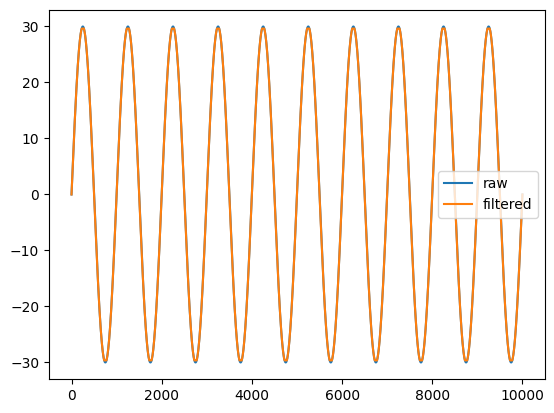

In [5]:
x_data, y_data = transform_to_numpy(raw)

# filter acceleration
qacc = y_data[:, 0]

# apply median filter with window 3
qacc_filtered = np.zeros_like(qacc)

import scipy.signal as signal

# apply median filter
qacc_filtered = signal.medfilt(qacc, 101)

plt.plot(qacc, label="raw")
plt.plot(qacc_filtered, label="filtered")
plt.legend()

# y_data = qacc_filtered.reshape(-1, 1)

In [6]:

proportion = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=proportion, random_state=42)

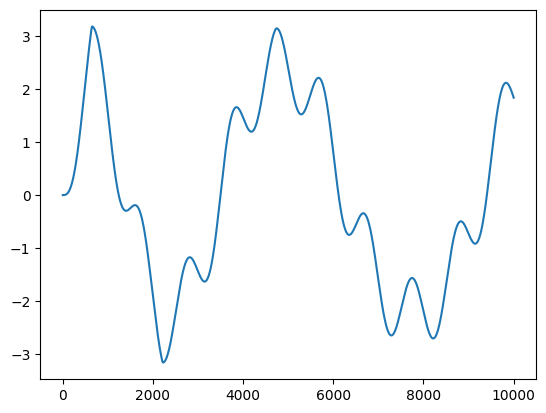

In [7]:
# target position
plt.plot(x_data[:, 0])

In [8]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=20,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=20,
    shuffle=True
)

In [9]:
class Naive(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dtype: torch.dtype = torch.float64):
        super(Naive, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Sigmoid(),
            nn.Linear(100, output_dim),
        ).type(dtype)

    def forward(self, x):
        return self.model(x)

In [10]:
def to_device(_device: torch.device, *tensors: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(_device) for t in tensors)


def train_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # best score for checkpointing
    _best = np.inf

    # training loop description
    _model.train()
    _train_loss = 0.0
    # iterate over dataset
    for i, data in enumerate(_train_loader, 1):
        _x, _y = to_device(_device, *data)

        # zero the parameter gradients
        _optimizer.zero_grad()

        # forward pass and loss calculation
        _outputs = _model(_x)
        _loss = _loss_fn(_outputs, _y)

        # backward pass
        _loss.backward()

        # optimizer run
        _optimizer.step()

        _train_loss += _loss.item()

    print(f'Epoch {_epoch_num}, Loss: {_train_loss / len(_train_loader)}')


def val_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _val_loader: DataLoader,
        _best: float,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # validation
    _val_loss = 0.0
    with torch.no_grad():
        _model.eval()  # evaluation mode
        for i, data in enumerate(_val_loader, 1):
            _x, _y = to_device(_device, *data)

            _outputs = _model(_x)
            _val_loss += _loss_fn(_outputs, _y).item()

        print(f'Validation {_epoch_num}, Loss: {_val_loss / len(_val_loader)}')

        if _val_loss / len(_val_loader) > _best:
            torch.save(_model.state_dict(), _ckpt_path)
            _best = _val_loss / len(_val_loader)
    return _best


def train(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _val_loader: DataLoader,
        _epochs: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    best = -float('inf')
    for epoch in range(_epochs):
        train_one_epoch(_model, _optimizer, _loss_fn, _train_loader, epoch, _device, _ckpt_path)
        best = val_one_epoch(_model, _optimizer, _loss_fn, _val_loader, best, epoch, _device, _ckpt_path)

In [11]:
device = 'cpu' # 'cuda' if torch.cuda.is_available else 'cpu'
model = Naive(x_data.shape[1], y_data.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
# writer = SummaryWriter()

In [12]:
train(model, optimizer, loss_fn, train_loader, val_loader, 30, device)

Epoch 0, Loss: 218.68654475754414
Validation 0, Loss: 77.53714121250685
Epoch 1, Loss: 38.99062759714729
Validation 1, Loss: 19.337765181717245
Epoch 2, Loss: 13.004779958948573
Validation 2, Loss: 10.137053267765873
Epoch 3, Loss: 7.666563247701822
Validation 3, Loss: 6.916715882047268
Epoch 4, Loss: 5.651261225147198
Validation 4, Loss: 5.252301376000479
Epoch 5, Loss: 4.54329254410088
Validation 5, Loss: 4.451855985802483
Epoch 6, Loss: 3.867028519861787
Validation 6, Loss: 3.701721207292049
Epoch 7, Loss: 3.428795009149773
Validation 7, Loss: 3.4346574608518385
Epoch 8, Loss: 3.134818235639983
Validation 8, Loss: 3.0501382287514964
Epoch 9, Loss: 2.9350340037028735
Validation 9, Loss: 2.8448217343497864
Epoch 10, Loss: 2.790962988214496
Validation 10, Loss: 2.694220985378614
Epoch 11, Loss: 2.689942874921554
Validation 11, Loss: 2.885125567092787
Epoch 12, Loss: 2.597202233072773
Validation 12, Loss: 2.4971630653183334
Epoch 13, Loss: 2.536983403868097
Validation 13, Loss: 2.474162

In [13]:
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

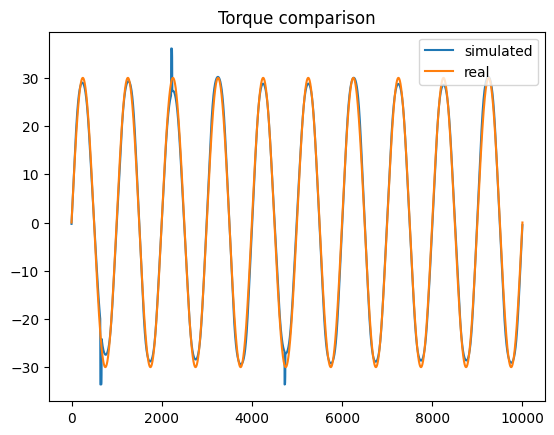

In [14]:
plt.title("Torque comparison")
plt.plot(predicted_torque, label="simulated")
plt.plot(y_data[:, 0], label="real")
plt.legend()

In [15]:
predicted_torque.shape, y_data.shape

((10001, 1), (10001, 1))

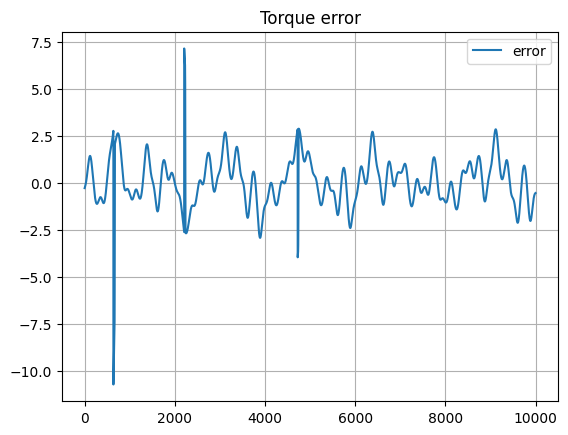

In [16]:
plt.title("Torque error")
plt.plot((predicted_torque - y_data), label="error")
plt.grid()
plt.legend()

# Try on another experiment

In [17]:
base = '../../data/raw'
data_path = 'pendulum/20231006143407765688.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path)
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

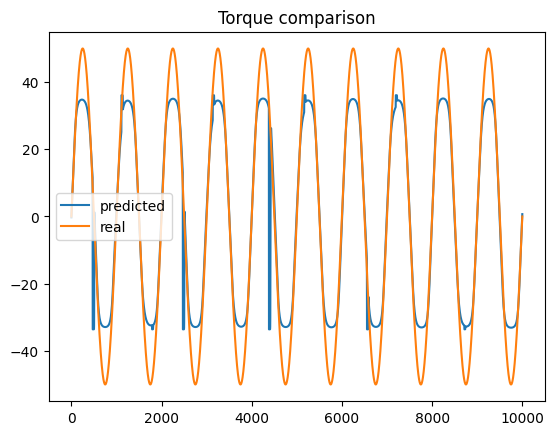

In [18]:
plt.title("Torque comparison")
plt.plot(predicted_torque, label="predicted")
plt.plot(y_data[:, 0], label="real")
plt.legend()

In [19]:
base = '../../data/raw'
data_path = 'pendulum/20231006143323978062.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path)
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

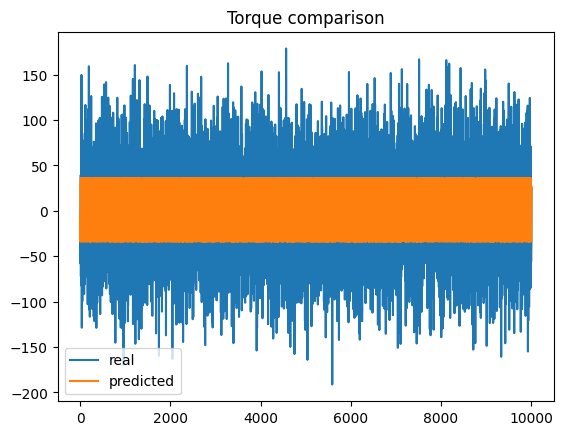

In [20]:
plt.title("Torque comparison")
plt.plot(y_data[:, 0], label="real")
plt.plot(predicted_torque, label="predicted")
plt.legend()

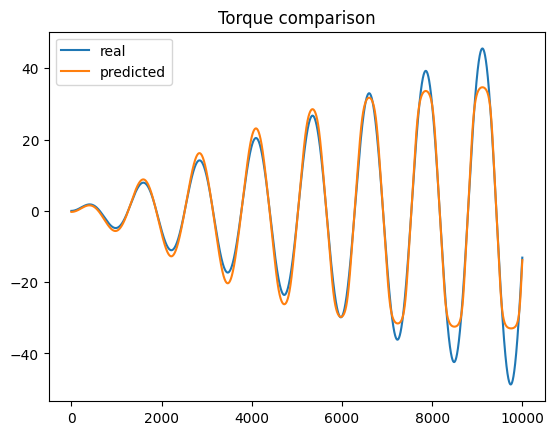

In [21]:
base = '../../data/raw'
data_path = 'pendulum/20231006144628546902.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path)
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

plt.title("Torque comparison")
plt.plot(y_data[:, 0], label="real")
plt.plot(predicted_torque, label="predicted")
plt.legend()